# Example 2

This notebook computes the total cross sections for processes of interest.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews.GenLauncher import GenLauncher


In [3]:
# targets
proton = dn.detector.NuclearTarget("H1")
C12 = dn.detector.NuclearTarget("C12")
Ar40 = dn.detector.NuclearTarget("Ar40")

In [4]:
def compute_xsecs(m4, mzprime, **kwargs):
   
    #########################
    # Set BSM parameters
    bsm_model = dn.model.create_model(mzprime=mzprime, m4 = m4, **kwargs)
    
    TARGETS = [proton, C12, Ar40]
    REGIMES = ['coherent','p-el']
    HEL_CASES = ['conserving','flipping']

    myMCs = {}
    for target in TARGETS:
        for regime in REGIMES:
            for hel in HEL_CASES:
                key = f'{target.name}_{hel}_{regime}'
                myMCs[key] = dn.MC.XsecCalc(  
                    bsm_model = bsm_model, 
                    scattering_regime = regime,
                    nuclear_target= target,
                    helicity = hel)

    mc_lowT=myMCs['Ar40_conserving_coherent']

    enu_axis = np.geomspace(mc_lowT.Ethreshold*0.99, 5, 10)
    np.append(mc_lowT.Ethreshold*1.01, enu_axis)
    sigmas = {}
    for key, mc in myMCs.items():
        sigmas[key] = []
        print(key)
        for enu in enu_axis:
            sigmas[key].append(mc.total_xsec(enu))
        sigmas[key] = np.array(sigmas[key])
        mc.sigmas = sigmas[key]
        mc.enu_axis = enu_axis
    return myMCs

In [5]:
mcs_H_150 = compute_xsecs(0.150, 1.25)
mcs_H_420 = compute_xsecs(0.420, 1.25)
mcs_L_150 = compute_xsecs(0.150, 0.03)
mcs_L_420 = compute_xsecs(0.420, 0.03)

Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
H1_c

In [32]:
import matplotlib.pyplot as plt

from matplotlib import rc, rcParams

# standard axis creator
def std_fig(axes_form=[0.1,0.15,0.88,0.74], transparent=True, figsize=(1.2*3.14961,1.4*2.3617)):
    fsize= 11
    rc('text', usetex=True)
    params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
                    'figure.figsize':figsize }
    rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
    rcParams.update(params)

    fig = plt.figure()
    ax = fig.add_axes(axes_form)
    if transparent:
        ax.patch.set_alpha(0.0)

    return fig, ax

# standard saving function
def std_savefig(fig, path):
    fig.savefig(path, dpi=400)


In [38]:
def plot_xsecs(theseMCs, regime = 'coherent'):
    fig, ax = std_fig(figsize=(10,4))

    all_args={
            f'H1_conserving_{regime}': {'color': 'black', 'ls': '-'},
            f'C12_conserving_{regime}': {'color': 'royalblue', 'ls': '-'},
            f'Ar40_conserving_{regime}': {'color': 'violet', 'ls': '-'},
            f'H1_flipping_{regime}': {'color': 'black', 'ls': '--'},
            f'C12_flipping_{regime}': {'color': 'royalblue', 'ls': '--'},
            f'Ar40_flipping_{regime}': {'color': 'violet', 'ls': '--'},
            }    
    
    for key, mc in theseMCs.items():
        if regime in key:
            if regime == 'coherent' and "H1" in key:
                continue
            else:
                sigmas = mc.sigmas
                enu_axis = np.geomspace(mc.Ethreshold*0.99, 5, len(sigmas))

                ls = '-' if ('conserving' in key) else '--'
                args = all_args[key]
                p = mc.ups_case.TheoryModel
                norm = (p.Umu4*p.epsilon*dn.const.eQED*p.gD*p.UD4*mc.target.Z)**2
#                 print(norm/(mc.ups_case.Vij**2*mc.ups_case.Vhad**2))
                if 'conserving' in key:
                    ax.plot(enu_axis, sigmas/norm, label=key.replace("_", " ").replace("conserving", "HC").replace("coherent", "coh"), **args)
                else:
                    ax.plot(enu_axis, sigmas/norm, **args)

    ax.set_title(fr'$m_{{Z^\prime}}= {mc.ups_case.mzprime:.2f}$ GeV,  $m_4 = {mc.ups_case.m_ups*1e3:.0f}$ MeV')
    ax.set_yscale("log")
    # ax.set_xscale("log")

    ax.set_xlabel(r"$E_\nu$ (GeV)")
    ax.set_ylabel(r"$\sigma/(Z e \epsilon V_{\mu 4})^2$ (cm$^2$)", fontsize=12)
    ax.set_xlim(0.1,np.max(enu_axis))
#     ax.set_ylim(1e-34,1e-26)

    ax.legend(loc="best", frameon=False)
    ax.grid(which='major', lw=0.5)

    # fig.savefig(f"plots/xsecs/example_3+1_{mc.ups_case.mzprime:.2f}_{mc.ups_case.m_ups*1e3:.0f}_{regime}.pdf")

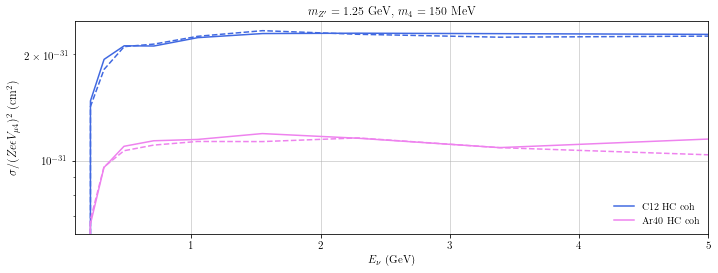

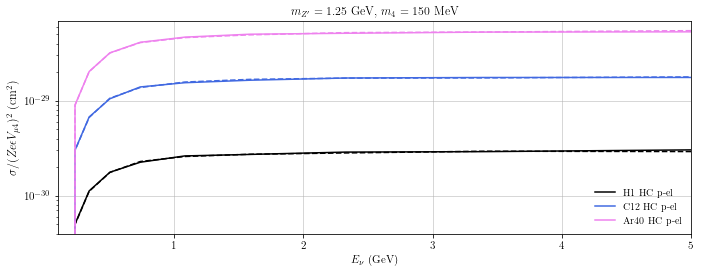

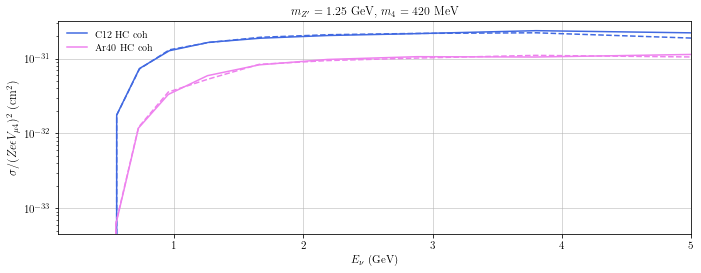

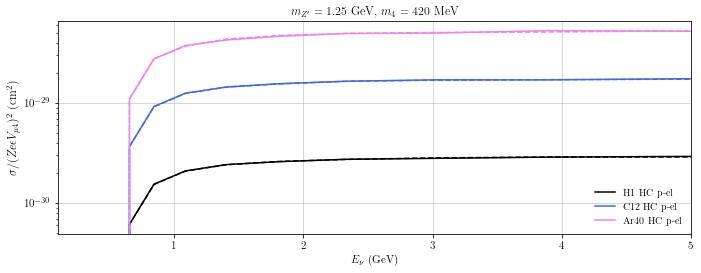

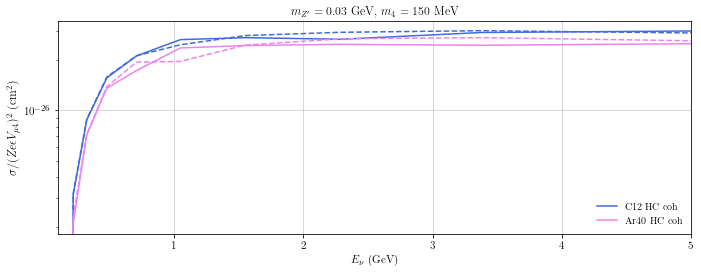

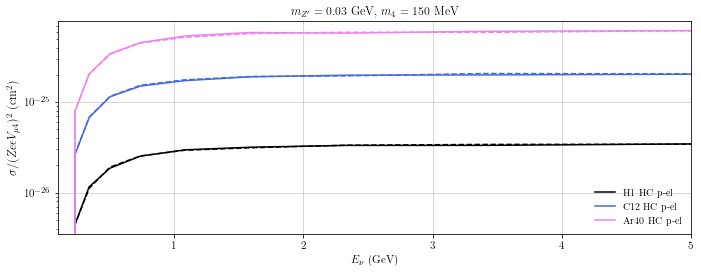

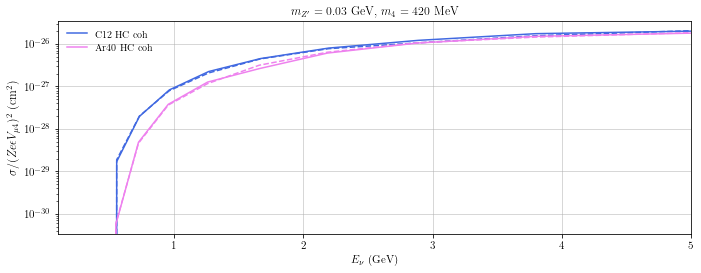

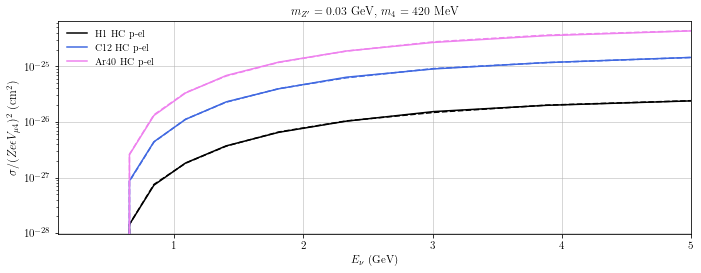

In [39]:
plot_xsecs(mcs_H_150, regime = 'coherent')
plot_xsecs(mcs_H_150, regime = 'p-el')
 
plot_xsecs(mcs_H_420, regime = 'coherent')
plot_xsecs(mcs_H_420, regime = 'p-el')
 
plot_xsecs(mcs_L_150, regime = 'coherent')
plot_xsecs(mcs_L_150, regime = 'p-el')
 
plot_xsecs(mcs_L_420, regime = 'coherent')
plot_xsecs(mcs_L_420, regime = 'p-el')

#### Dirac vs Majorana

In [9]:
mcs_L_420

{'H1_conserving_coherent': <DarkNews.MC.XsecCalc at 0x129e7d1f0>,
 'H1_flipping_coherent': <DarkNews.MC.XsecCalc at 0x129e7d3d0>,
 'H1_conserving_p-el': <DarkNews.MC.XsecCalc at 0x129e7d430>,
 'H1_flipping_p-el': <DarkNews.MC.XsecCalc at 0x129e7d520>,
 'C12_conserving_coherent': <DarkNews.MC.XsecCalc at 0x129e7d5e0>,
 'C12_flipping_coherent': <DarkNews.MC.XsecCalc at 0x129e7d9a0>,
 'C12_conserving_p-el': <DarkNews.MC.XsecCalc at 0x129e7d280>,
 'C12_flipping_p-el': <DarkNews.MC.XsecCalc at 0x129e7d8e0>,
 'Ar40_conserving_coherent': <DarkNews.MC.XsecCalc at 0x129e7daf0>,
 'Ar40_flipping_coherent': <DarkNews.MC.XsecCalc at 0x129e7dca0>,
 'Ar40_conserving_p-el': <DarkNews.MC.XsecCalc at 0x129e7dd00>,
 'Ar40_flipping_p-el': <DarkNews.MC.XsecCalc at 0x129e7dd60>}

In [14]:
mcs_L_420['C12_conserving_coherent'].diff_xsec_Q2(Enu=11, Q2 = 0.001)

array([7.05370673e+09])

(1, 1000000000000.0)

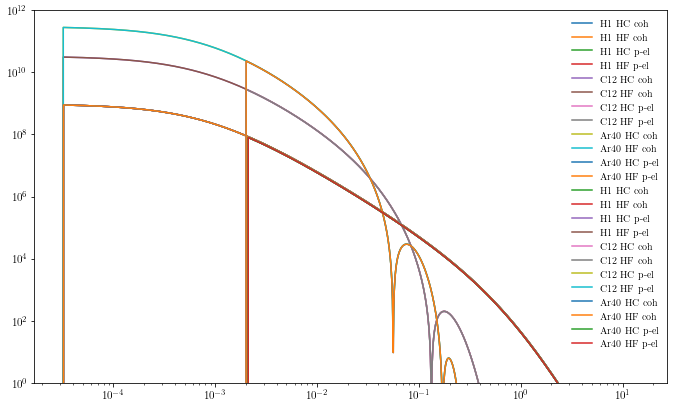

In [41]:
from DarkNews import phase_space as ps
Enu = 2
fig, ax = std_fig(axes_form=[0.1,0.15,0.88,0.74], transparent=True, figsize=(10,7))
def plot_diff_xsec_Q2(MCs, Enu):
    
    for key, mc in MCs.items():
        Q2range=np.geomspace(ps.upscattering_Q2min(Enu, mc.ups_case.m_ups, mc.ups_case.MA),
                    ps.upscattering_Q2max(Enu, mc.ups_case.m_ups, mc.ups_case.MA),
                    1000)
        ax.plot(Q2range, mc.diff_xsec_Q2(Enu=Enu, Q2 = Q2range), label = f'{key}'.replace('_', ' ').replace('flipping','HF').replace('conserving','HC').replace('coherent','coh'))


plot_diff_xsec_Q2(mcs_L_150, Enu)
plot_diff_xsec_Q2(mcs_L_420, Enu)
ax.legend(loc='best', frameon=False)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1,1e12)